In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.patches import Patch, Circle
import warnings
warnings.filterwarnings('ignore')

In [2]:
edge_color = '#30011E'
background_color = '#fafafa'

sns.set_style({
    'font.family':'serif',
    'figure.facecolor':background_color,
    'axes.facecolor':background_color,
})

In [3]:
counties = gpd.read_file('data/cb_2018_us_county_500k/')
counties = counties[~counties.STATEFP.isin(['72', '69', '60', '66', '78'])]
counties = counties.set_index('GEOID')

states = gpd.read_file('data/cb_2018_us_state_500k/')
states = states[~states.STATEFP.isin(['72', '69', '60', '66', '78'])]

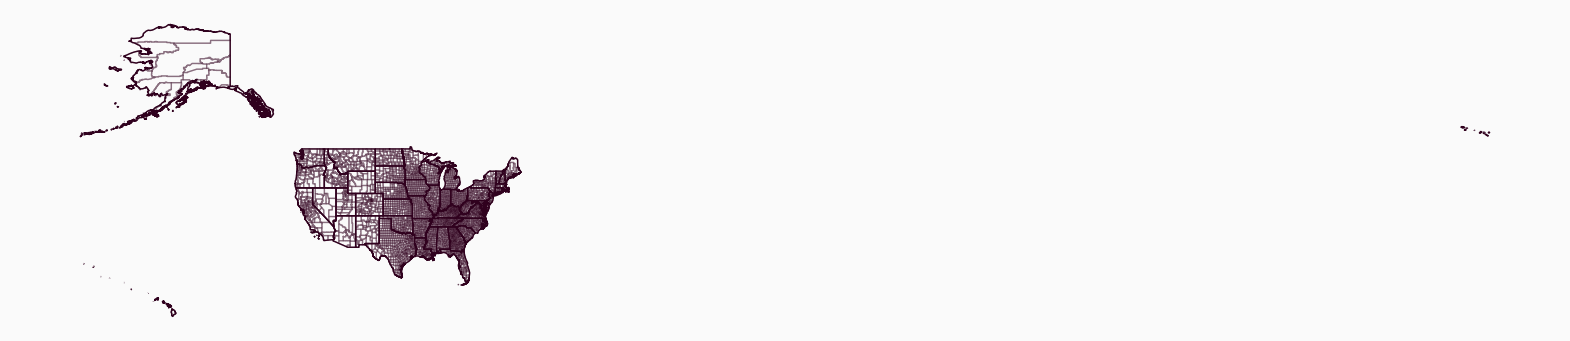

In [4]:
ax = counties.plot(edgecolor=edge_color + '55', color='None', figsize=(20, 20))
states.plot(ax=ax, edgecolor=edge_color, color='None', linewidth=1)

plt.axis('off')
plt.show()

In [5]:
counties = counties.to_crs('ESRI:102003')
states = states.to_crs('ESRI:102003')

In [6]:
def translate_geometries(df, x, y, scale, rotate):
    df.loc[:, 'geometry'] = df.copy().geometry.translate(yoff=y, xoff=x)
    center = df.copy().dissolve().centroid.iloc[0]
    df.loc[:, 'geometry'] = df.copy().geometry.scale(xfact=scale, yfact=scale, origin=center)
    df.loc[:, 'geometry'] = df.copy().geometry.rotate(rotate, origin=center)
    return df

In [7]:
def adjust_maps(df):
    df_main_land = df.copy().loc[~df.STATEFP.isin(['02', '15'])]
    df_alaska = df.copy().loc[df.STATEFP == '02']
    df_hawaii = df.copy().loc[df.STATEFP == '15']
    
    df_alaska = translate_geometries(df_alaska, 1300000, -4900000, 0.5, 32)
    df_hawaii = translate_geometries(df_hawaii, 5400000, -1500000, 1, 24)
    
    return pd.concat([df_main_land, df_alaska, df_hawaii])

In [8]:
counties = adjust_maps(counties)
states = adjust_maps(states)

In [9]:
facebook_df = pd.read_csv('data/county_county.tsv', sep='\t')
facebook_df.user_loc = ('0' + facebook_df.user_loc.astype(str)).str[-5:]
facebook_df.fr_loc = ('0' + facebook_df.fr_loc.astype(str)).str[-5:]

In [10]:
county_id = '06075' # San Francisco
county_name = counties.loc[county_id].NAME
county_facebook_df = facebook_df[facebook_df.user_loc == county_id]

In [11]:
selected_color = '#FA26A0'
data_breaks = [
    (90, '#00ffff', 'Top 10%'),
    (70, '#00b5ff', '90-70%'),
    (50, '#6784ff', '70-50%'),
    (30, '#aeb3fe', '50-30%'),
    (0, '#e6e5fc', 'Bottom 30%'),
]

In [12]:
def create_color(county_df, data_breaks):
    colors = []

    for i, row in county_df.iterrows():
        for p, c, _ in data_breaks:
            if row.value >= np.percentile(county_df.value, p):
                colors.append(c)
                break

    return colors

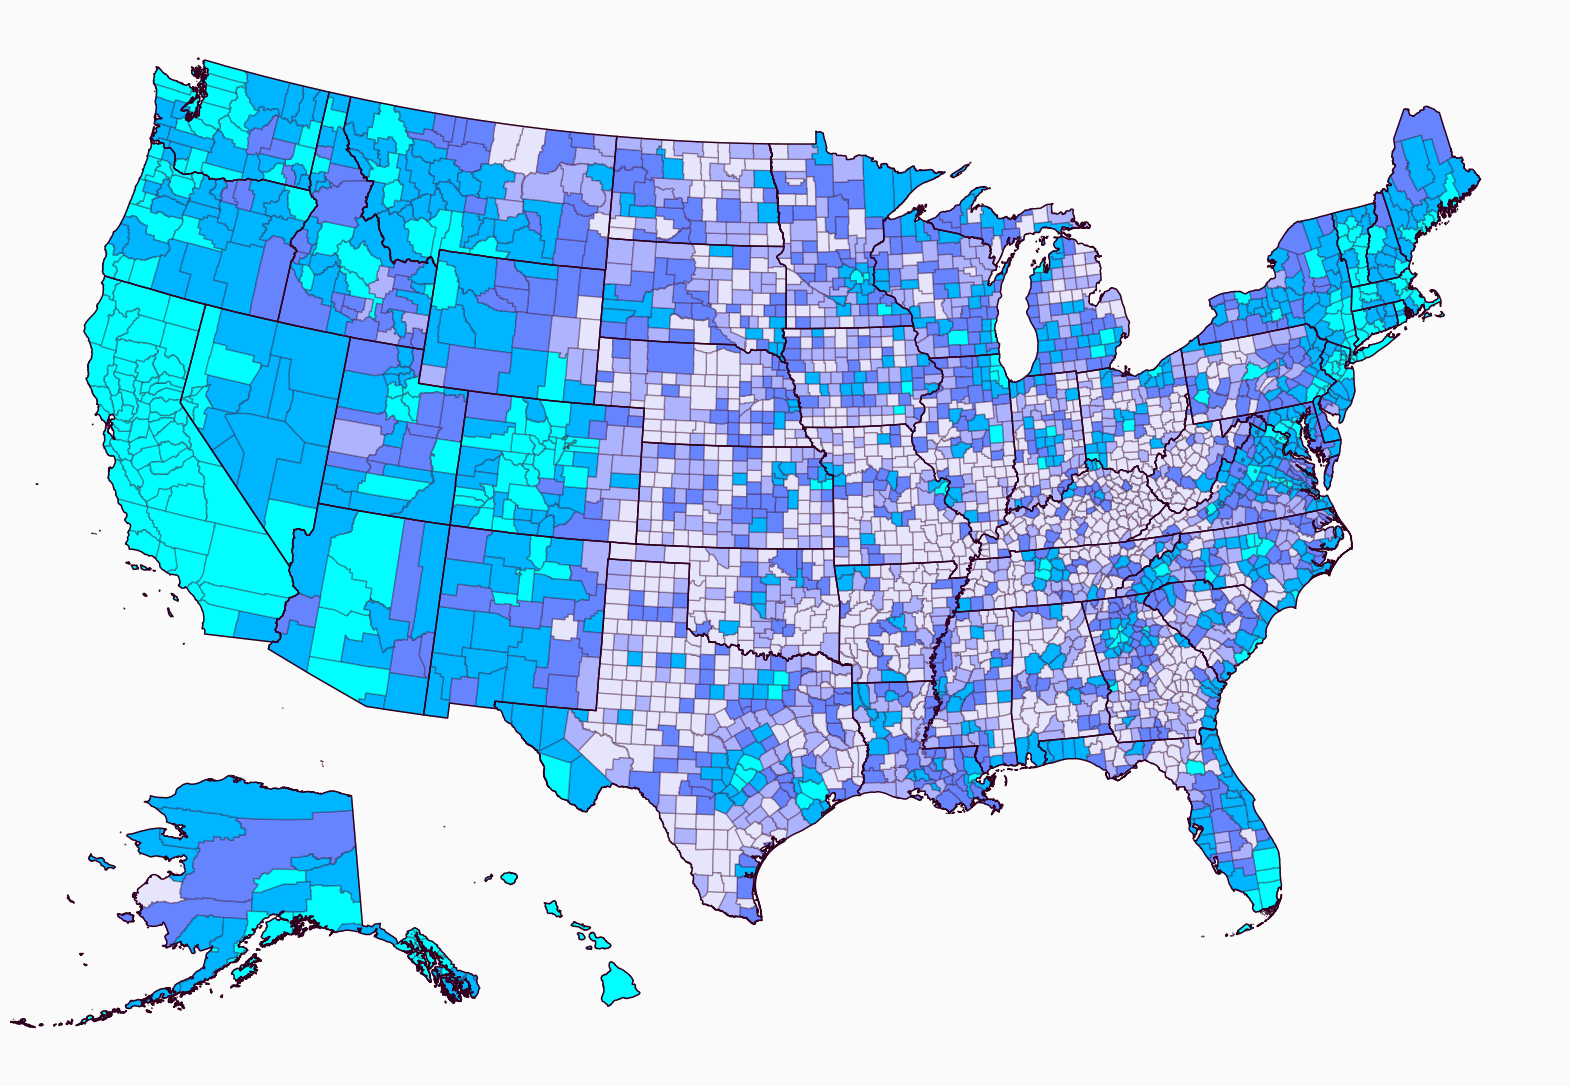

In [13]:
counties.loc[:, 'value'] = (county_facebook_df.set_index('fr_loc').scaled_sci)
counties.loc[:, 'value'] = counties['value'].fillna(0)
counties.loc[:, 'color'] = create_color(counties, data_breaks)
counties.loc[county_id, 'color'] = selected_color

ax = counties.plot(edgecolor=edge_color + '55', color=counties.color, figsize=(20, 20))
states.plot(ax=ax, edgecolor=edge_color, color='None', linewidth=1)
ax.set(xlim=(-2600000, None)) # Removing some of the padding to the left

plt.axis('off')
plt.show()